提供了2018年1月1日至2018年12月31日的标的第一期的还款数据作为训练集，需要选手预测2019年2月1日至2019年3月31日成交标的第一期的还款情况。同时还提供了相关的标的属性信息，借款用户基础信息、画像标签和行为日志等数据供选手使用。

In [1]:
import pandas as pd # package for high-performance, easy-to-use data structures and data analysis
import numpy as np # fundamental package for scientific computing with Python
from collections import Counter
import matplotlib
import pickle
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()



from numpy import array
from matplotlib import cm
# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings("ignore")

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. 表一  标的属性表（listing_info.csv）500万条,共90万的用户数量,训练集和测试集混合,时间范围:2016-07-05, 2019-03-31,难怪数据记录这么多的!!!

In [66]:
listing_info=pd.read_csv("../data/listing_info.csv")

In [68]:
listing_info.shape,listing_info['user_id'].unique().shape

((5484891, 6), (928195,))

In [16]:
listing_info.head(1)

,user_id,listing_id,auditing_date,term,rate,principal
0,316610,1556649,2017-11-26,9,7.6,4800


In [32]:
# 检查缺省值
total = listing_info.isnull().sum().sort_values(ascending = False)
percent = (listing_info.isnull().sum()/listing_info.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
principal,0,0.0
rate,0,0.0
term,0,0.0
auditing_date,0,0.0
listing_id,0,0.0


In [42]:
listing_info['term'].unique()

array([ 9,  6, 12,  3])

In [71]:
listing_info['rate'].describe()

count    5.484891e+06
mean     7.936558e+00
std      7.410161e-01
min      6.500000e+00
25%      7.200000e+00
50%      8.000000e+00
75%      8.600000e+00
max      9.300000e+00
Name: rate, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f043b5120f0>],
      dtype=object)

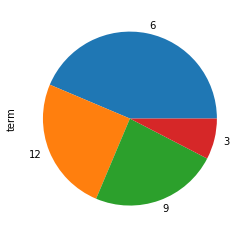

In [60]:
listing_info_term = listing_info['term'].value_counts()
listing_info_term.plot(kind='pie',subplots=True)

In [43]:
listing_info['principal'].unique()

array([ 4800,  4000,  8660, ..., 34830, 40420, 27690])

In [72]:
# 时间取值范围
date=np.array(listing_info['auditing_date'].unique())
date.sort()
print("%d days,first day:%s, last day:%s"%(date.shape[0]-1,date[0],date[-1]))

997 days,first day:2016-07-05, last day:2019-03-31


# 2.表二 提交格式

In [5]:
submission=pd.read_csv("../data/submission.csv")

In [17]:
submission.shape

(3987078, 3)

In [53]:
submission.head(5)

,listing_id,repay_amt,repay_date
0,5431438,4.3309,2019-03-12
1,5431438,4.3309,2019-03-13
2,5431438,4.3309,2019-03-14
3,5431438,4.3309,2019-03-15
4,5431438,4.3309,2019-03-16


# 3.表三  测试集,共13万条数据,没有重复的,时间范围:2019-02-01, 2019-03-31

In [2]:
# 13万条
test=pd.read_csv("../data/test.csv")

In [4]:
# 一个用户对应着一条标
test.shape,test['user_id'].unique().shape,test['listing_id'].unique().shape

((130000, 5), (130000,), (130000,))

In [21]:
test.head(5)

,user_id,listing_id,auditing_date,due_date,due_amt
0,498765,5431438,2019-03-12,2019-04-12,138.5903
1,34524,5443211,2019-03-15,2019-04-15,208.0805
2,821741,5461707,2019-03-22,2019-04-22,421.2097
3,263534,5472320,2019-03-26,2019-04-26,212.6537
4,238853,5459750,2019-03-21,2019-04-21,817.4593


In [ ]:
# 检测测试集合和数据集是否重合
print("test not train:%d,train not test: %d,train and test%d"%(ret_list_1,ret_list_2,ret_list_3))

In [54]:
test['due_amt'].describe()

count    130000.000000
mean        425.554718
std         490.551979
min          54.569900
25%         147.667600
50%         270.962000
75%         500.765200
max       15018.086300
Name: due_amt, dtype: float64

In [34]:
# 检查缺省值
total = test.isnull().sum().sort_values(ascending = False)
percent = (test.isnull().sum()/test.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
due_amt,0,0.0
due_date,0,0.0
auditing_date,0,0.0
listing_id,0,0.0
user_id,0,0.0


In [7]:
test.head(1)

,user_id,listing_id,auditing_date,due_date,due_amt
0,498765,5431438,2019-03-12,2019-04-12,138.5903


In [56]:
# 预测数据
test_days=np.array(test['auditing_date'].unique())
test_days.sort()
print("%d days,first day: %s, last days: %s"%(test_days.shape[0],test_days[0],test_days[-1]))

59 days,first day: 2019-02-01, last days: 2019-03-31


In [57]:
# 预测数据
test_days=np.array(test['due_date'].unique())
test_days.sort()
print("%d days,first day: %s, last days: %s"%(test_days.shape[0],test_days[0],test_days[-1]))

58 days,first day: 2019-03-01, last days: 2019-04-30


In [96]:
# 测试直接按照规定天数,规定额度还款
testSubmission=pd.DataFrame()
testSubmission['listing_id']=test['listing_id']
testSubmission['repay_date']=test['due_date']
testSubmission['repay_amt']=test['due_amt']
testSubmission.to_csv('./testSubmission.csv',index=False)

# 4.表四: train,训练用户和测试用户重合量不大,训练集总共100万,共80多万用户,即有20万个表存在重复, 时间范围:2018-01-01, 2019-01-31,还款日和到期日之间的差距为0-31,而且绝大部分是3天,还款的金额也是绝大部分和账单数值相等!

In [20]:
# 100万条
train=pd.read_csv("../data/train.csv")

In [3]:
train.head(5)

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.7045
2,404196,2355665,2018-02-18,2018-03-18,307.9270,\N,\N
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.9809
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.6503


In [63]:
train.shape,train['user_id'].unique().shape

((1000000, 7), (823732,))

In [68]:
train['due_date']=train['due_date'].replace('\\N','2200-01-01')
train['repay_date']=train['repay_date'].replace('\\N','2200-01-01')
train['repay_amt']=train['repay_amt'].replace('\\N','0')

In [80]:
train.head(5)

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt,dategap,paygap
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167,0 days,0
1,672952,3698760,2018-06-09,2018-07-09,258.7045,2018-07-08,258.7045,1 days,0
2,404196,2355665,2018-02-18,2018-03-18,307.9270,2200-01-01,0,-66398 days,-307
3,342769,1994522,2018-01-13,2018-02-13,252.9809,2018-02-13,252.9809,0 days,0
4,828139,3602352,2018-06-01,2018-07-01,107.6503,2018-06-25,107.6503,6 days,0


In [91]:
# 还款日和到期日之间的差距
train['due_date']=pd.to_datetime(train['due_date'])
train['repay_date']=pd.to_datetime(train['repay_date'])
train['dategap']=(train['due_date']-train['repay_date'])

train['dategap'] = pd.to_timedelta(train['dategap']).dt.days
train.loc[train['dategap']<0,'dategap']=-1

train['dategap'].describe()

count    1000000.000000
mean           3.542536
std            7.119228
min           -1.000000
25%            0.000000
50%            0.000000
75%            3.000000
max           31.000000
Name: dategap, dtype: float64

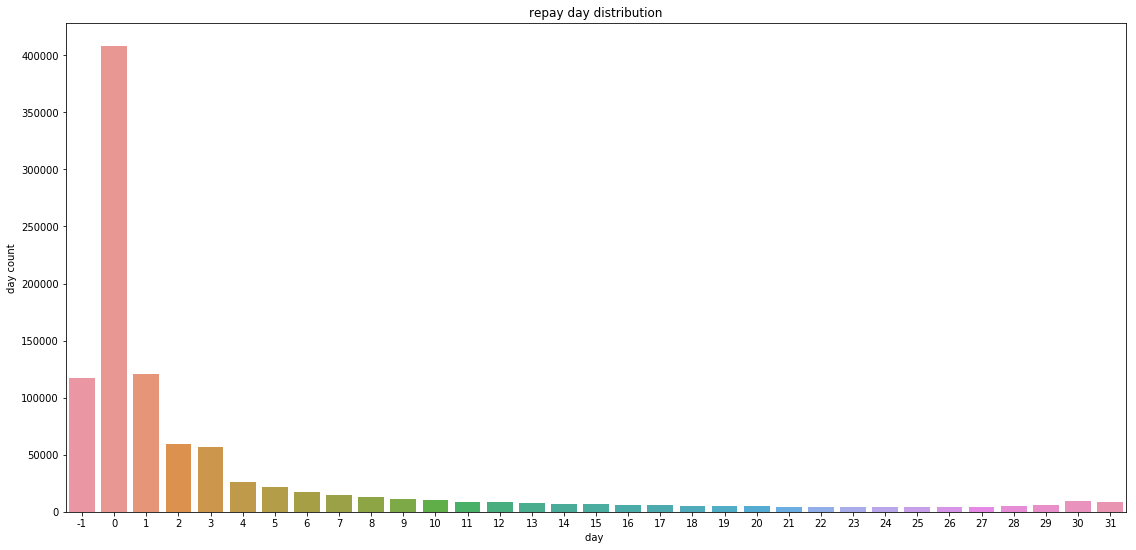

In [90]:
date_gap_distribution = train['dategap'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(19,9))
sns.barplot( date_gap_distribution.index,date_gap_distribution.values, ax=ax)
ax.set(xlabel= 'day ', 
       ylabel = 'day count', 
       title = "repay day distribution")
plt.show()

In [73]:
# 还款和账单之间的差距,说明绝大部分的还款是按时的,按量还款的
train['paygap']=(train['repay_amt'].astype('float')-train['due_amt'])
train['paygap'].describe()

count    1000000.000000
mean         -55.427952
std          237.278817
min       -16553.000000
25%            0.000000
50%            0.000000
75%            0.000000
max            0.000000
Name: paygap, dtype: float64

In [61]:
# 查看训练集和测试集中数据用户是否重合
train_user_id = np.array(train['user_id'])
train_user_list=set(train_user_id.tolist())

test_user_id = np.array(test['user_id'])
test_user_list=set(test_user_id.tolist())
# 在测试集中,没在训练集
ret_list_1 = test_user_list-train_user_list
# 在训练集,没在测试集
ret_list_2 = train_user_list-test_user_list
# 在训练集,也在测试集
ret_list_3 = train_user_list&test_user_list
print("test, not in train: %d,train not in test: %d,both in test and train: %d"%(len(ret_list_1),len(ret_list_2),len(ret_list_3)))

test, not in train: 104463,train not in test: 798195,both in test and train: 25537


In [55]:
train['due_amt'].describe()

count    1000000.000000
mean         452.026625
std          514.202155
min           17.453300
25%          160.482400
50%          286.740100
75%          546.026800
max        18827.018400
Name: due_amt, dtype: float64

In [35]:
# 检查缺省值
total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
repay_amt,0,0.0
repay_date,0,0.0
due_amt,0,0.0
due_date,0,0.0
auditing_date,0,0.0


In [3]:
train.head(1)

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167


In [24]:
# 训练集中只有两个标,历史上就有很多的标
train.loc[train['user_id']==748147]

,user_id,listing_id,auditing_date,due_date,due_amt,repay_date,repay_amt
0,748147,3163926,2018-04-25,2018-05-25,72.1167,2018-05-25,72.1167
610984,748147,4905220,2018-11-13,2018-12-13,54.9781,2018-12-13,54.9781


In [48]:
# 时间取值范围
date=np.array(train['repay_date'].unique())
date.sort()
print("%d days,first day:%s, last day:%s"%(date.shape[0]-1,date[0],date[395]))

396 days,first day:2018-01-01, last day:2019-01-31


In [ ]:
# 重点研究每一标还款日和到期日之间的差距


# 7.表七:用户还款日志表（user_repay_logs.csv）,总共1800万条记录,test中用户8920没在log中, train中44434用户没在log中

In [6]:
# 日志1800万条
user_repay_logs=pd.read_csv("../data/user_repay_logs.csv")

In [28]:
user_repay_logs.shape

(18001297, 7)

In [22]:
user_repay_logs.loc[user_repay_logs['user_id']==748147]

,user_id,listing_id,order_id,due_date,due_amt,repay_date,repay_amt
1490926,748147,3131591,6,2018-10-22,102.1022,2018-10-22,102.1022
1490927,748147,3131591,3,2018-07-22,102.1022,2018-07-22,102.1022
1490928,748147,3131591,2,2018-06-22,102.1022,2018-04-24,102.1022
1490929,748147,3131591,5,2018-09-22,102.1022,2018-09-22,102.1022
1490930,748147,3131591,1,2018-05-22,102.1022,2018-04-24,102.1022
1490931,748147,3131591,4,2018-08-22,102.1022,2018-08-22,102.1022
9606398,748147,3163926,5,2018-09-25,72.1167,2018-09-25,72.1167
9606399,748147,3163926,4,2018-08-25,72.1167,2018-08-25,72.1167
9606400,748147,3163926,1,2018-05-25,72.1167,2018-05-25,72.1167
9606401,748147,3163926,3,2018-07-25,72.1167,2018-07-25,72.1167


#### 分期数目的频次统计:可能被分为1---12期(疑问?是不是日志不完整呢)
#### 每一个人借钱次数的统计: 借钱一两次的人还是要多一点点

Counter({6: 899606, 3: 675598, 1: 607557, 2: 591724, 5: 473560, 4: 465364, 9: 184107, 7: 108482, 12: 84960, 8: 77819, 10: 27592, 11: 20207})


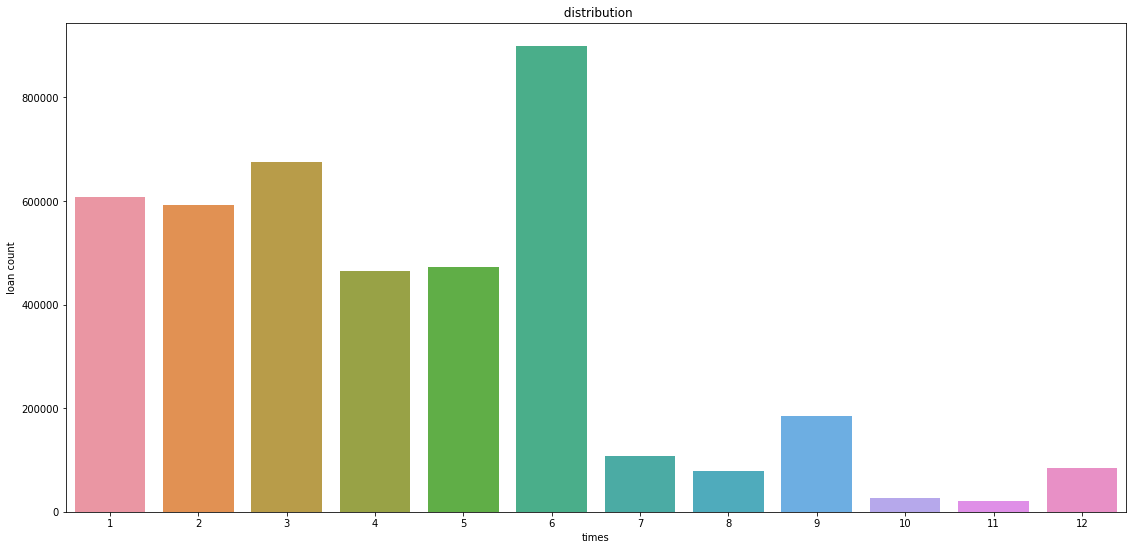

In [47]:
# 分期数目的统计
listing_id_count = user_repay_logs['listing_id'].value_counts().sort_values(ascending=False)
counter = Counter(listing_id_count)
print(counter)

x=[]
y=[]
for k,v in counter.items():
    x.append(k)
    y.append(v)
fig, ax = plt.subplots(figsize=(19,9))
sns.barplot(x,y, ax=ax)
ax.set(xlabel= 'times', 
       ylabel = 'loan count', 
       title = " distribution")
plt.show()

Counter({1: 218906, 2: 133596, 3: 99342, 4: 78581, 5: 63237, 6: 51009, 7: 42022, 8: 36094, 9: 30448, 10: 25613, 11: 21105, 12: 16987, 13: 13363, 14: 10587, 15: 8037, 16: 6126, 17: 4719, 18: 3593, 19: 2640, 20: 1977, 21: 1545, 22: 1134, 23: 907, 24: 697, 25: 551, 26: 400, 27: 313, 28: 251, 29: 194, 30: 146, 31: 123, 32: 86, 33: 77, 34: 63, 35: 59, 36: 52, 41: 29, 37: 29, 40: 23, 38: 22, 39: 20, 43: 19, 42: 17, 45: 13, 44: 11, 46: 9, 52: 7, 47: 7, 51: 6, 49: 6, 57: 5, 54: 4, 60: 3, 50: 3, 48: 3, 65: 2, 55: 2, 53: 2, 132: 1, 107: 1, 93: 1, 92: 1, 91: 1, 84: 1, 77: 1, 75: 1, 74: 1, 71: 1, 70: 1, 67: 1, 66: 1, 64: 1, 63: 1, 62: 1, 61: 1, 59: 1, 56: 1})


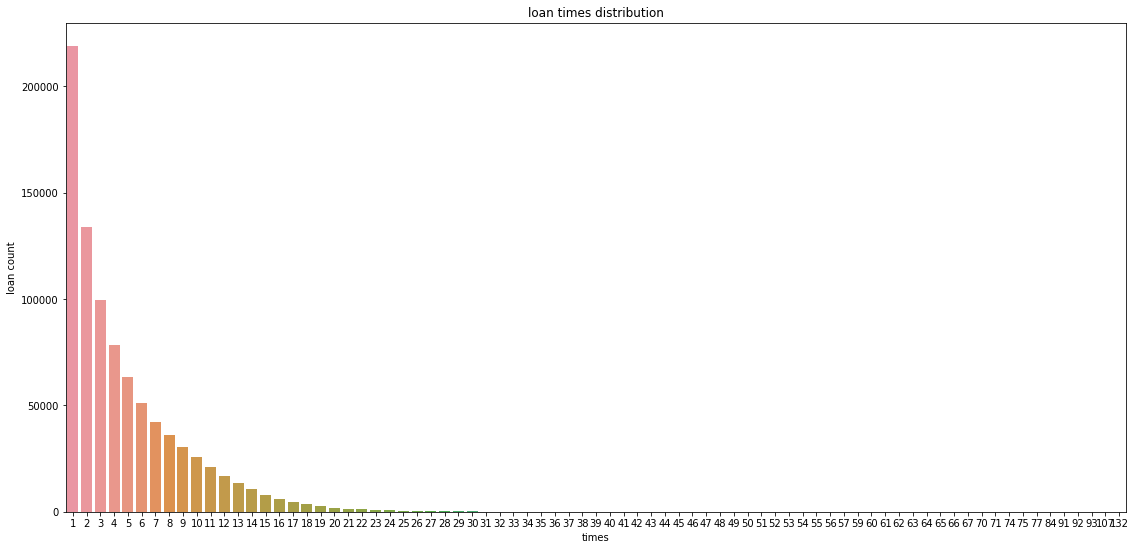

In [46]:
# 借钱次数的统计(就是每一个人可能有几个标,(一个标被分成了很多期1-12))
# 分期数目的统计
# 删除重复的行(标),之后统计用户的数目!!!
drop_duplicates_loan=user_repay_logs.drop_duplicates(subset=['listing_id'], keep='first')
loan_count=drop_duplicates_loan['user_id'].value_counts().sort_values(ascending=False)
counter = Counter(loan_count)
print(counter)

x=[]
y=[]
for k,v in counter.items():
    x.append(k)
    y.append(v)
fig, ax = plt.subplots(figsize=(19,9))
sns.barplot(x,y, ax=ax)
ax.set(xlabel= 'times', 
       ylabel = 'loan count', 
       title = "loan times distribution")
plt.show()

In [6]:
due_amt=np.array(train['due_amt'])
repay_amt=np.array(train['repay_amt'])

(1000000,)

In [17]:
# 账单和还款相等
count=0
for i in range(1000000):
    if str(due_amt[i])==repay_amt[i]:
        count+=1
print(count)

In [23]:
# 还款为空
count_none=0
for i in range(1000000):
    if repay_amt[i]=="\\N":
        count_none+=1
print(count_none)

117192


In [30]:
# 账单和还款不想等
test=[]
count_bigger=0
count_lower=0
# 检查repay_amt是不是数值
for i in range(1000000):
    try:
        if due_amt[i]<float(repay_amt[i]):
            count_bigger+=1
        elif(due_amt[i]>float(repay_amt[i])):
            count_lower+=1
    except:
        test.append(repay_amt[i])
test=np.array(test)
print(set(test))
print(count_bigger)
print(count_lower)

{'\\N'}
17906
8286


### due_amt和repay_amt
| * | == | > | < | None |
| ---| --- | --- | --- | --- |
|Count | 856616 | 117192 | 8286 | 17906 |

In [37]:
# 检查缺省值
total = user_repay_logs.isnull().sum().sort_values(ascending = False)
percent = (user_repay_logs.isnull().sum()/user_repay_logs.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
repay_amt,0,0.0
repay_date,0,0.0
due_amt,0,0.0
due_date,0,0.0
order_id,0,0.0


In [92]:
# 最多有12期
user_repay_logs['order_id'].unique()

array([ 6,  4,  7,  5,  1,  2,  3, 11, 10,  9,  8, 12])

In [94]:
train_user_id=set(train['user_id'].tolist())
test_user_id=set(test['user_id'].tolist())
log_user_id=set(user_repay_logs['user_id'].tolist())

# 判断test中user使用全在log中
test_in_log=test_user_id-log_user_id
# 判断train中user使用全在log中
train_in_log=train_user_id-log_user_id
print(len(train_user_id),len(test_user_id))
print(len(test_in_log),len(train_in_log))

823732 130000
8920 44434


# 5. 借款用户操作行为日志表（user_behavior_logs.csv）,只有三种操作方式

In [9]:
# 借款用户日志 5000万
user_behavior_logs=pd.read_csv("../data/user_behavior_logs.csv")

In [24]:
user_behavior_logs.shape

(55781271, 3)

In [25]:
user_behavior_logs.head(5)

,user_id,behavior_time,behavior_type
0,842439,2018-09-13 23:17:21,3
1,842439,2018-09-13 23:17:21,3
2,905214,2018-09-13 15:19:30,3
3,905214,2018-09-13 15:19:30,3
4,842439,2018-09-13 23:17:21,3


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f04166a5a90>],
      dtype=object)

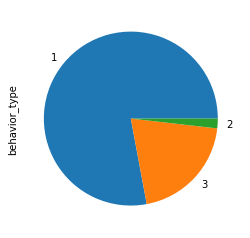

In [69]:
behavior_type = user_behavior_logs['behavior_type'].value_counts()
behavior_type.plot(kind='pie',subplots=True)

In [39]:
# 检查缺省值
total = user_behavior_logs.isnull().sum().sort_values(ascending = False)
percent = (user_behavior_logs.isnull().sum()/user_behavior_logs.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
behavior_type,0,0.0
behavior_time,0,0.0
user_id,0,0.0


In [44]:
# 取值检查
user_behavior_logs['behavior_type'].unique()

array([3, 2, 1])

# 6. 借款用户基础信息表（user_info.csv）,基础信息表格覆盖了整个train,test,log文件,没有信息缺省,(ps:用户画像表格数据就有缺省)

In [48]:
# 90万用户信息
user_info=pd.read_csv("../data/user_info.csv")

In [26]:
user_info.shape

(954209, 8)

In [27]:
user_info.head(10)

,user_id,reg_mon,gender,age,cell_province,id_province,id_city,insertdate
0,483833,2017-04,男,19,c29,c26,c26241,2018-12-11
1,156772,2016-05,男,31,c11,c11,c11159,2018-02-13
2,173388,2016-05,男,34,c02,c02,c02182,2018-08-21
3,199107,2016-07,女,25,c09,c09,c09046,2018-06-05
4,122560,2016-03,男,23,c05,c05,c05193,2018-04-02
5,550399,2017-06,男,30,c08,c07,c07282,2018-04-19
6,414650,2017-02,男,53,c12,c12,\N,2018-10-16
7,275042,2016-10,女,23,c21,c21,c21174,2018-07-10
8,184180,2016-06,男,29,c04,c04,c04348,2018-02-08
9,817503,2018-03,男,25,c06,c25,c25199,2018-11-27


In [95]:
# 判断train,test,log用户信息是否在user_info中
train_user_id=set(train['user_id'].tolist())
test_user_id=set(test['user_id'].tolist())
log_user_id=set(user_repay_logs['user_id'].tolist())
user_info_user_id=set(user_info['user_id'].tolist())

# 判断test中user使用全在user_info中
test_in_info=test_user_id-user_info_user_id

# 判断train中user使用全在user_info中
train_in_info=train_user_id-user_info_user_id

# 判断log中user使用全在user_info中
log_in_info=log_user_id-user_info_user_id

print(len(train_user_id),len(test_user_id),len(log_user_id))
print(len(test_in_info),len(train_in_info),len(log_in_info))

823732 130000 874841
0 0 0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f041671cfd0>],
      dtype=object)

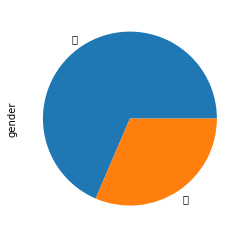

In [68]:
gender = user_info['gender'].value_counts()
gender.plot(kind='pie',subplots=True)

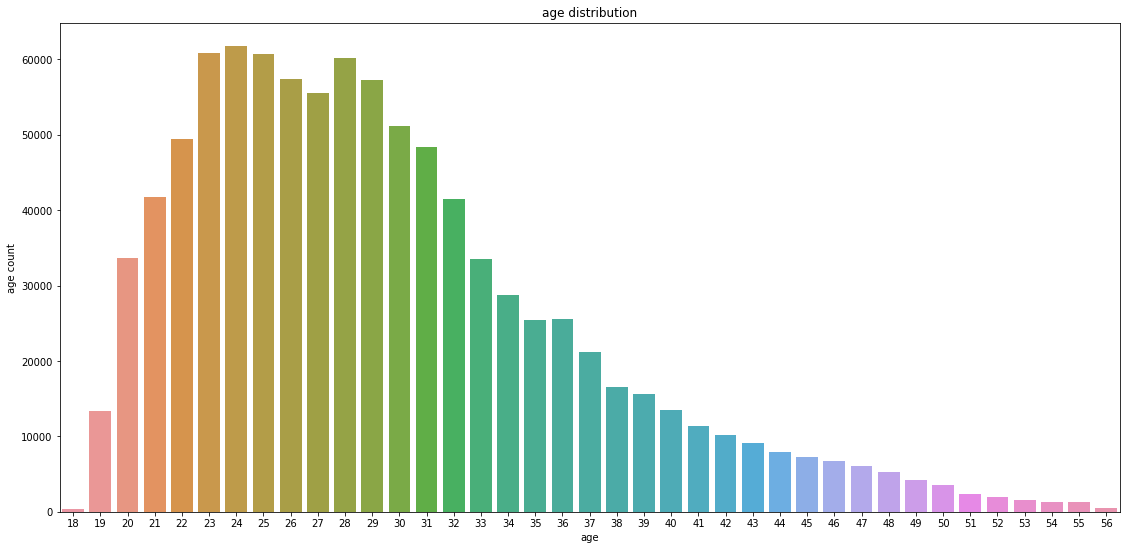

In [67]:
age = user_info['age'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(19,9))
sns.barplot( age.index,age.values, ax=ax)
ax.set(xlabel= 'age', 
       ylabel = 'age count', 
       title = "age distribution")
plt.show()

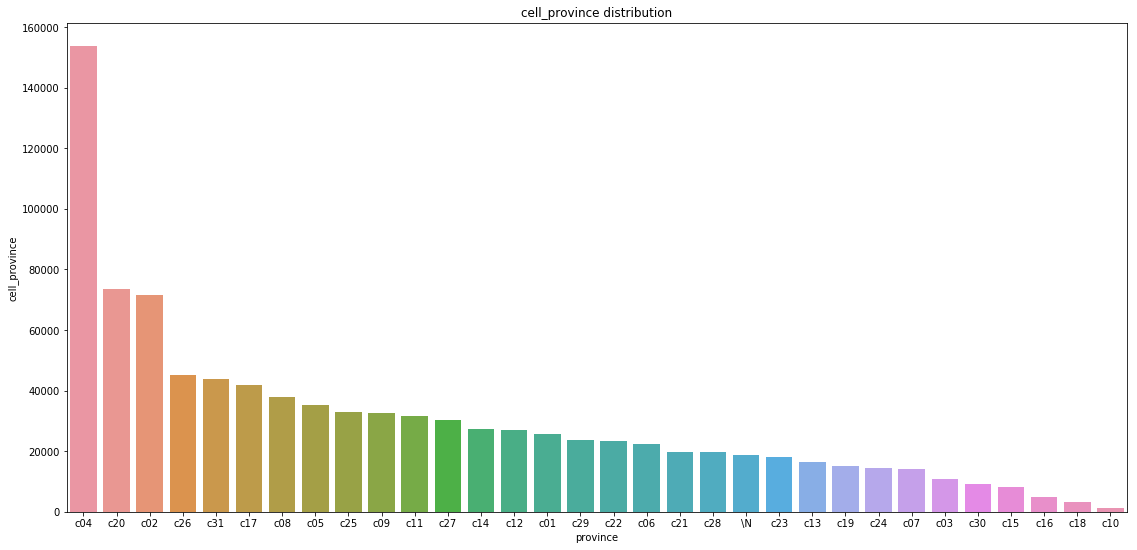

In [63]:
cell_province = user_info['cell_province'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(19,9))
sns.barplot( cell_province.index,cell_province.values, ax=ax)
ax.set(xlabel= 'province', 
       ylabel = 'cell_province', 
       title = "cell_province distribution")
plt.show()

['c26' 'c11' 'c02' 'c09' 'c05' 'c07' 'c12' 'c21' 'c04' 'c25' 'c08' 'c27'
 'c15' 'c23' 'c20' 'c28' 'c06' 'c29' 'c17' 'c16' 'c13' 'c24' 'c01' 'c31'
 'c30' 'c19' 'c03' 'c22' 'c14' 'c18' 'c10']


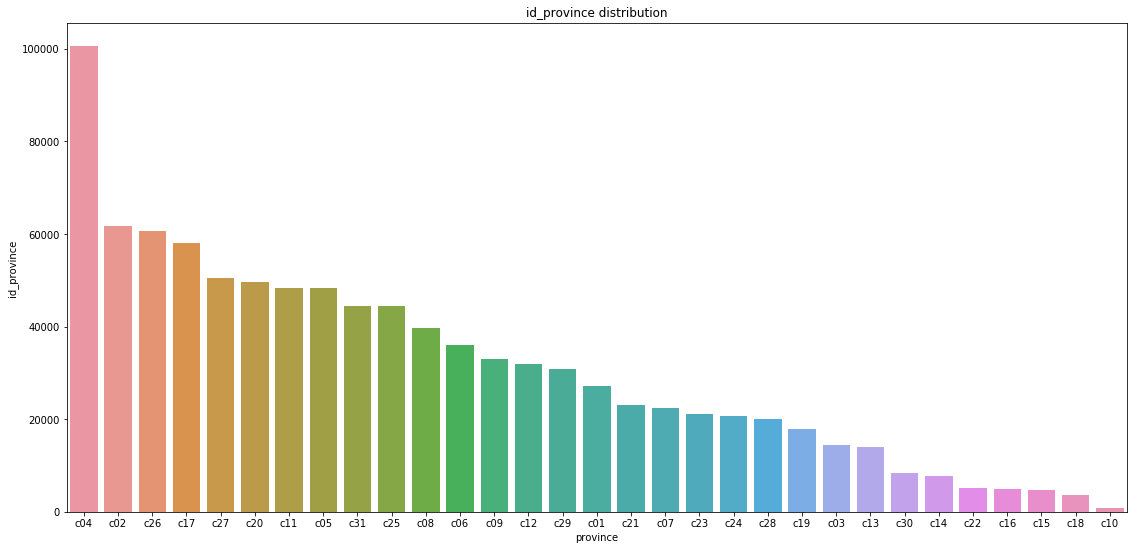

In [53]:
print(user_info['id_province'].unique())
id_province = user_info['id_province'].value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(19,9))
sns.barplot( id_province.index,id_province.values, ax=ax)
ax.set(xlabel= 'province', 
       ylabel = 'id_province', 
       title = "id_province distribution")
plt.show()

(356,)


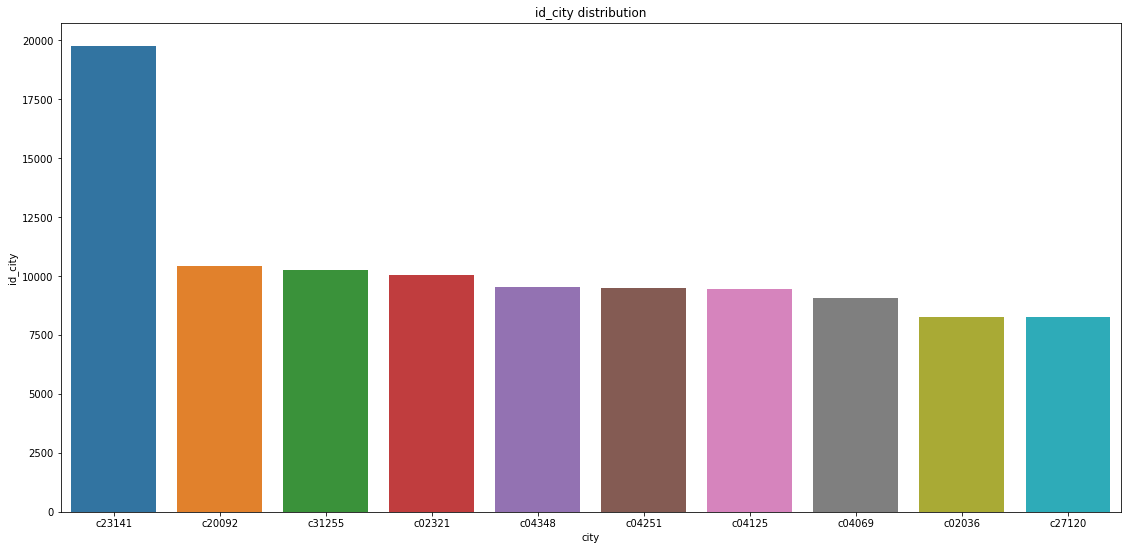

In [52]:
# 总共356个城市,前10的如下
citys=user_info['id_city'].unique().shape
print(citys)
id_city = user_info['id_city'].value_counts().sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(19,9))
sns.barplot( id_city.index,id_city.values, ax=ax)
ax.set(xlabel= 'city', 
       ylabel = 'id_city', 
       title = "id_city distribution")
plt.show()

In [38]:
# 检查缺省值
total = user_info.isnull().sum().sort_values(ascending = False)
percent = (user_info.isnull().sum()/user_info.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
insertdate,0,0.0
id_city,0,0.0
id_province,0,0.0
cell_province,0,0.0
age,0,0.0


In [55]:
# 性别年龄
user_info['gender'].unique(),user_info['age'].unique()

(array(['男', '女'], dtype=object),
 array([19, 31, 34, 25, 23, 30, 53, 29, 22, 35, 20, 39, 38, 21, 24, 36, 32,
        45, 28, 33, 27, 40, 26, 42, 46, 44, 37, 41, 51, 50, 52, 43, 47, 48,
        49, 54, 56, 18, 55]))

# 8.用户画像标签列表（user_taglist.csv）,和其他的数据集均不能够完全匹配,即存在用户画像数据的缺失

In [3]:
# 用户画像只有60万,有的用户的画像找不到!!!
user_taglist=pd.read_csv("../data/user_taglist.csv")

In [17]:
user_taglist.shape

(615160, 3)

In [31]:
user_taglist.head(10)

,user_id,taglist,insertdate
0,113401,4707|473|3498|4759|1654|298|2869|1164|212|1885...,2018-10-03
1,378358,751|2207|1100|2099|1832|1911|5347|2254|171|360...,2018-11-30
2,434838,877|3795|5628|70|2684|691|719|4228|631|1541|12...,2018-03-25
3,577061,2431|3242|340|1823|4020|4357|164|620|2168|1192...,2018-05-25
4,566753,3980|3125|1819|1333|1177|3972|621|5800|3632|16...,2018-12-02
5,257271,3688|141|1059|1616|247|3527|2788|2431|2706|234...,2018-06-20
6,286758,4073|5474|1583|449|244|676|2306|3755|440|3688|...,2018-03-12
7,279566,2266|1330|3744|424|2018|1318|436|2410|956|2785...,2018-07-15
8,842520,2018|4288|3133|5733|2212|181|942|2072|3440|165...,2018-06-07
9,374058,440|4185|2264|4381|1137|1059|3760|2649|620|530...,2018-04-11


In [98]:
# 判断train,test,log用户信息是否在user_info中
train_user_id=set(train['user_id'].tolist())
test_user_id=set(test['user_id'].tolist())
log_user_id=set(user_repay_logs['user_id'].tolist())
user_info_user_id=set(user_info['user_id'].tolist())
user_taglist_user_id=set(user_taglist['user_id'].tolist())


# 判断test中user使用全在tag中
test_in_tag=test_user_id-user_taglist_user_id

# 判断train中user使用全在tag中
train_in_tag=train_user_id-user_taglist_user_id

# 判断log中user使用全在tag中
log_in_tag=log_user_id-user_taglist_user_id

# 判断info中user使用全在tag中
info_in_tag=user_info_user_id-user_taglist_user_id

print(len(train_user_id),len(test_user_id),len(log_user_id),len(user_info_user_id))
print(len(train_in_tag),len(test_in_tag),len(log_in_tag),len(info_in_tag))

823732 130000 874841 928195
352264 50214 372223 392815


In [4]:
# 用户画像有5000多个维度,使用聚类算法聚类,将缺省的统一算为0,tag取值范围为range(1,5986)
user_taglist_detail=user_taglist['taglist'].tolist()
temp=[]
for s in user_taglist_detail:
    temp+=s.split("|")
temp=set(temp)
tags=[]
for i in temp:
    if(i=="\\N"):
        tags.append(0)
        continue
    tags.append(int(i))
tags.sort()
print(len(tags),tags[0],tags[-1])

5986 0 5985


In [5]:
# 聚类或者降维
# 用户画像有5000多个维度,使用聚类算法聚类,将缺省的统一算为0,tag取值范围为range(1,5986)
# 稀疏矩阵,以下运算非常占用内存,速度缓慢!
# user_taglist_detail=user_taglist['taglist'].tolist()
# user_tags=[]
# for s in user_taglist_detail:
#     tags=np.zeros(5986)
#     temp=s.split("|")
#     index=[]
#     for i in temp:
#         if(i=="\\N"):
#             break
#         index.append(int(i))
#     tags[index]=1
#     user_tags.append(tags)
# user_tags_df=pd.DataFrame(user_tags)
# columns=["t_%d"%i in range(5986)]
# user_tags_df.columns=columns

In [36]:
# 检查缺省值
total = user_taglist.isnull().sum().sort_values(ascending = False)
percent = (user_taglist.isnull().sum()/user_taglist.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head()

,Total,Percent
insertdate,0,0.0
taglist,0,0.0
user_id,0,0.0
